## The data describes the Bank of England's statistics on spot exchange rates for the Euro into US dollars.

### Importing the required libraries which will be used as a part of the forecasting process.

In [6]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)
import warnings
warnings.filterwarnings("ignore")

In [7]:
df_fx_date = pd.read_csv('XUDLERD.csv')
df_fx_date.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


### Convert the date to datatime using pandas to_datetime and set it as the index of the dataframe for further analysis.

In [8]:
df_fx_date['Date'] = pd.to_datetime(df_fx_date.Date)
df_fx_date.set_index('Date', inplace=True)
df_fx_date.sort_index(inplace=True)
ts = df_fx_date['Value']
ts.head()

Date
1975-01-02    0.7633
1975-01-03    0.7585
1975-01-06    0.7524
1975-01-07    0.7510
1975-01-08    0.7554
Name: Value, dtype: float64

### Plot this time series data with daily frequency to see how Euro is trending against US dollar.

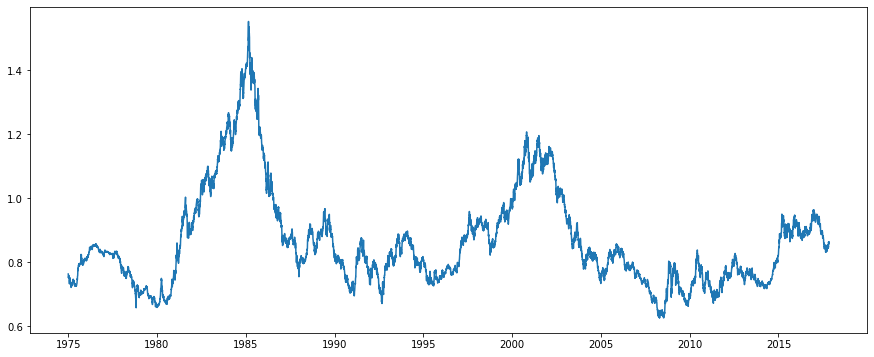

In [9]:
_ = plt.plot(ts)

### Using the daily data for the time series contains too much variation, so let us resample the data by week and use this to predict the exchange rates.

In [10]:
ts_week = ts.resample('W').mean()

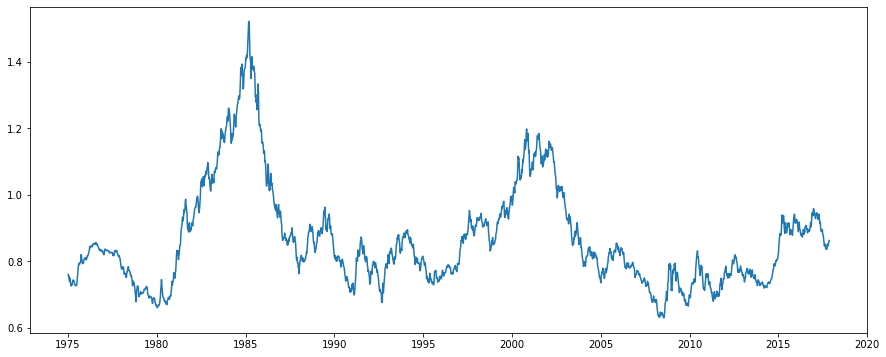

In [11]:
_ = plt.plot(ts_week)

### Let's create a function to plot to moving variance and observe if it remains constant over time, however, we might not always be able to make such visual inference and hence, let us apply the Dicky Fuller Test as well to check for stationarity.

In [12]:
def test_stationarity(timeseries):
    """ Fucntion to plot the moving variance and apply Dickey Fuller Test"""
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original Time Series Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Meand & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value' ,'#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
        
    
    print(dfoutput)    

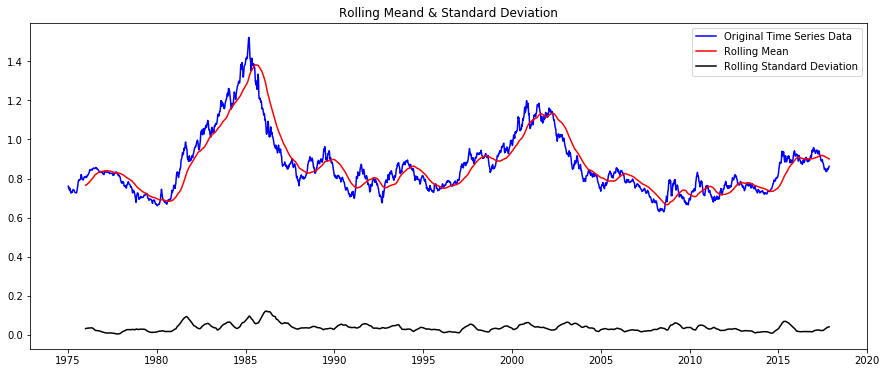

Results of Dickey-Fuller Test:

Test Statistics                  -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value 1%                -3.433281
Critical Value 5%                -2.862835
Critical Value 10%               -2.567459
dtype: float64


In [13]:
test_stationarity(ts_week)

### Inference drawn from Dickey Fuller Test
- Because the test statictics is more than the 5% critical value and the p-value is greater than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected.
- This shows the our weekely time series is not stationary.
- #### Before we can apply ARIMA model for forecasting, we need to transform this time series into a stationary time series.

### We can apply differencing to stationarize our data. We will undergo log transformation before differencing for better results.

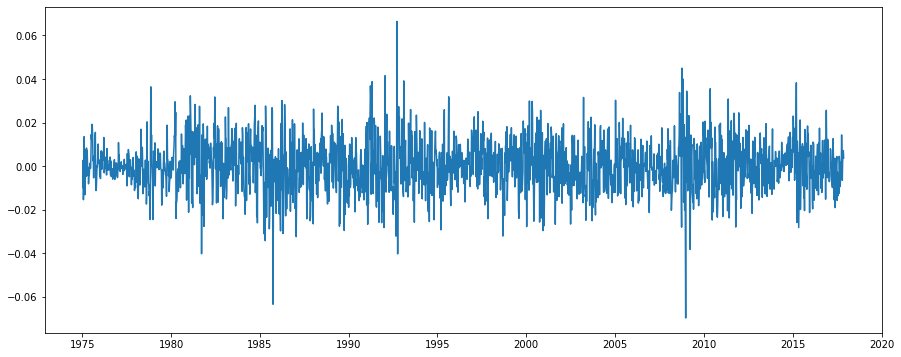

In [14]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
_ = plt.plot(ts_week_log_diff)

### Let us perform a confirmation with Dickey Fuller test again.

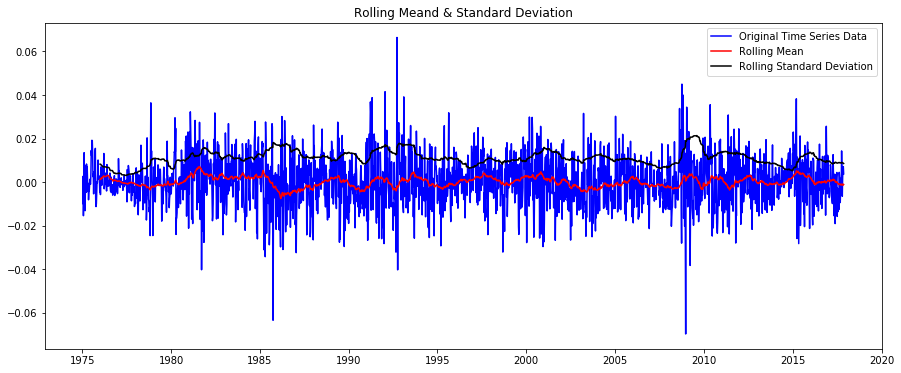

Results of Dickey-Fuller Test:

Test Statistics                 -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value 1%                -3.433279
Critical Value 5%                -2.862834
Critical Value 10%               -2.567459
dtype: float64


In [15]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

### Inference drawn after stationarizing the time series.
- The test statictics is significantly less than the 1% critical value, which shows that our time series is now stationary with 99% confidence.

- #### Now we can begin to apply the ARIMA model for forecasting.

### Let us define ACF & PACF
- ACF and PACF help to determine the p, d and q model parameters which we will need later as input for the ARIMA model.

In [16]:
# ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

### Plot ACF and PACF

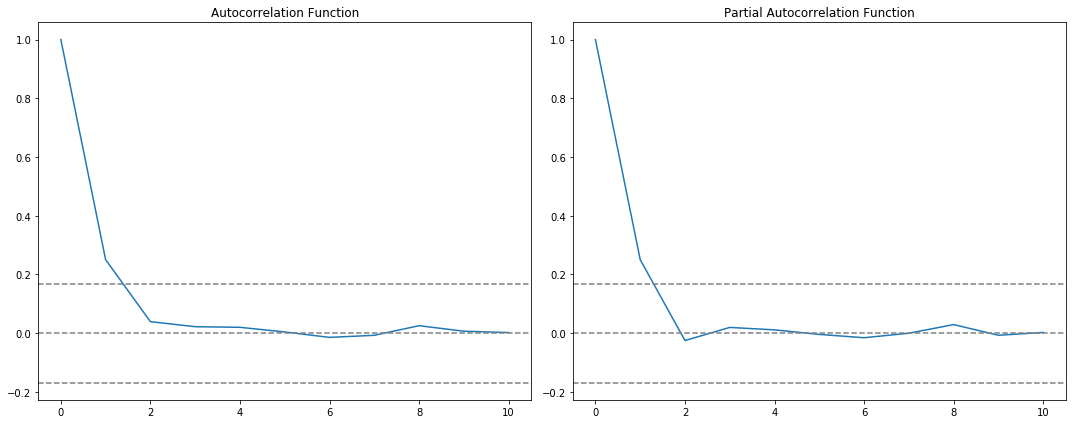

In [17]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Inferences drawn post ACF and PACF Plot
#### Using the plot, the value of p and q can be determined as follows
- p: The lag value where the PACF cuts off (drops to zero) for the first time. For us, this value is 2. So we have p=2

- q: The lag value where the ACF plot crosses the upper confidence interval for the first time. So, q=1.

### Now let us plot the ARIMA model

Text(0.5, 1.0, 'RSS: 0.2806')

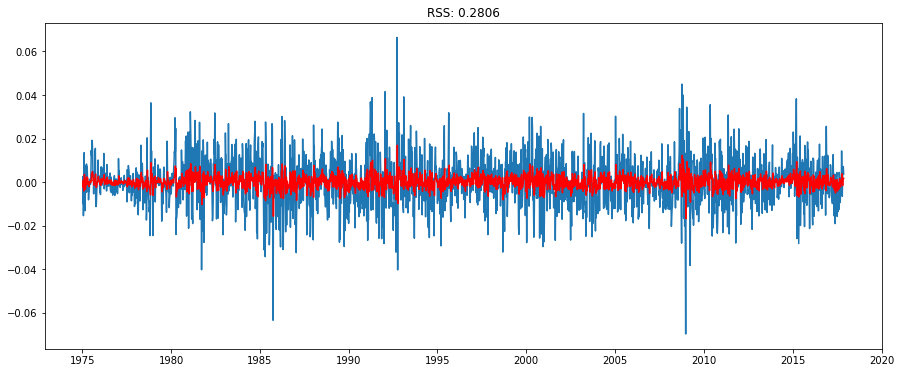

In [18]:
model = ARIMA(ts_week_log, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(f'RSS: {round(sum((results_ARIMA.fittedvalues - ts_week_log_diff)**2),4)}')

### Residual Analysis - Now let us see the results of the ARIMA model and plot the residuals.

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sun, 29 Sep 2019   AIC                         -13731.202
Time:                        03:20:20   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

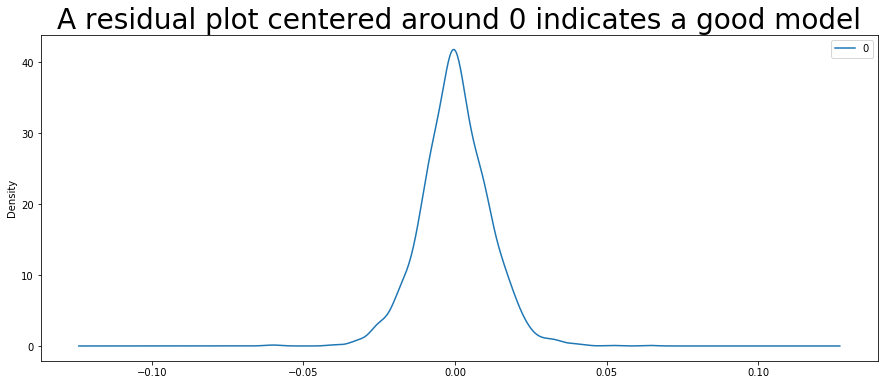

In [21]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.title('A residual plot centered around 0 indicates a good model', fontdict={'fontsize':28})
print(residuals.describe())

### Time to perform predictions

In [22]:
# Predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


### Scaling predictions
- Now that the model is returning the results, we can scale the model predictions back to the original scale.
- Remove the first order differencing we did and take exponent to restore the predictions back to their original scale.

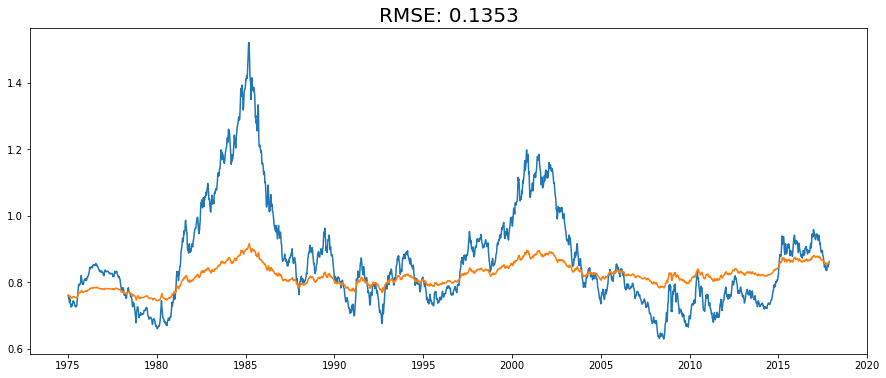

In [26]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
_ = plt.title(f'RMSE: {round(np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)),4)}', fontdict={'fontsize': 20})

## The RMSE is close enough to 0, so the model predictions are accurate.

### Training and Testing:
- Now we need to split the data into train and test samples.
- We will use the traning data to train the ARIMA model and perform out-of-sample forecasting.
- Then we will compare the results of our out-of-sample predictions for Euro rates with the actual values from the test data.

In [27]:
# Training and Testing Datasets
size = int(len(ts_week_log) -15)
train, test = ts_week_log[0: size], ts_week_log[size: len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...\n')

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print(f'Predicted= {np.exp(yhat)}, expected= {round(np.exp(obs), 4)} ')

Printing Predicted vs Expected Values...

Predicted= [0.85545892], expected= 0.8462 
Predicted= [0.84362759], expected= 0.85 
Predicted= [0.85129876], expected= 0.8518 
Predicted= [0.85206231], expected= 0.8465 
Predicted= [0.84514685], expected= 0.8385 
Predicted= [0.83666553], expected= 0.8362 
Predicted= [0.83578104], expected= 0.8376 
Predicted= [0.83804973], expected= 0.8359 
Predicted= [0.83538368], expected= 0.8479 
Predicted= [0.85112559], expected= 0.8518 
Predicted= [0.8524885], expected= 0.8463 
Predicted= [0.84490639], expected= 0.848 
Predicted= [0.848604], expected= 0.8533 
Predicted= [0.85455175], expected= 0.8594 
Predicted= [0.86085273], expected= 0.8626 


### Validating the model:
- Validate the model by comparing its out-of-sample predictions for Euro rates with the actual values from the test data and calculate the Mean Squared Error (MSE)

In [28]:
error = mean_squared_error(test, predictions)
print('Mean Squared Error of Predictions...')
print('Test MSE: %.6f' %error)

predictions_series = pd.Series(predictions, index=test.index)

Mean Squared Error of Predictions...
Test MSE: 0.000043


### Now, let us plot the forecasted values vs Observed Values.

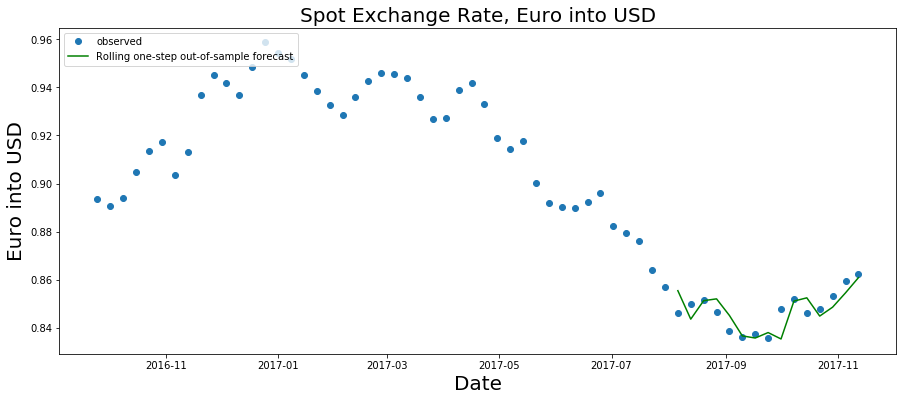

In [29]:
plt.plot(ts_week[-60:], 'o', label='observed')
plt.plot(np.exp(predictions_series), 'g', label='Rolling one-step out-of-sample forecast')
plt.title('Spot Exchange Rate, Euro into USD', fontdict={'fontsize': 20})
plt.xlabel('Date', fontdict={'fontsize': 20})
plt.ylabel('Euro into USD', fontdict={'fontsize': 20})
lenend = plt.legend(loc='upper left')